# Recap

# Трансформеры

# Задача NTP

# Loss

[**CrossEntropyLoss**](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)

# Из чего состоят - encoder, decoder

# Какие типы внимания есть в трансформерах

# Что где QKV в крос атеншне

# Для чего нужна маска внимания?

# Чем отличаются от RNN?


## Attention

**Цель слоя Attention:** моделирование влияний и взаимодействий между токенами для обучения контекстных эмбэддингов

Попробуем рассмотреть на примере




In [ ]:
mha = nn.MultiheadAttention(embed_dim=64, num_heads=8, batch_first=True)

batch_size = 3
seq_len = 7
embedding_dim = 64
q = k = v = torch.rand([batch_size, seq_len, embedding_dim])

attn_output, attn_output_weights = mha.forward(q, k, v)

In [ ]:
# Каждый полученный контекстный эмбэддинг
# создержит взвешенную сумму всех других
# эмбэддингов внутри последовательности
attn_output.shape

torch.Size([3, 7, 64])

In [ ]:
attn_output_weights.shape

torch.Size([3, 7, 7])

**Вопрос!** Зачем после того как мы получили контекстные эмбэддинги, запускать еще один слой трансформера?

[ The animated Transformer: the Transformer model explained the fun way!](https://youtu.be/NzLwHcqE6Jw?t=365)

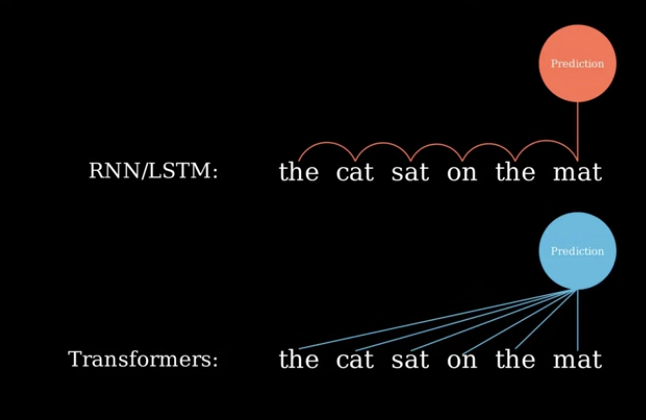

### Зачем нужен Scaled Dot-Product Attention?

Скейл (деление на корень из размерности) позволяет лучше протекать градиентам.

Если не скейлить, то числа под софтмаксом получаются большими после перемножения матриц.
Большие по модулю числа в софтмаксе могут привести к сильному и значительному перевешиванию одного из чисел. Из-за чего градиенты по остальным интексам не потекут


https://ai.stackexchange.com/a/42197





In [ ]:
import torch
import torch.nn as nn
softmax = nn.Softmax(dim=0)

# предположим, что мы посчитали q @ k.T для размерности 256
# и в результате мы могли получить числа с СКО 16
attention_qkt = torch.tensor([ -0.16, -0.8, 0.0, 0.8, 0.16 ])

# not scaled softmax
softmax( attention_qkt )

tensor([1.2660e-14, 3.7739e-11, 1.1250e-07, 3.3535e-04, 9.9966e-01])

In [ ]:
# scaled softmax
softmax( attention_qkt / 16 )

tensor([0.0580, 0.0956, 0.1577, 0.2600, 0.4287])

# Pretrained Transformers

## [T5 - Exploring the Limits of Transfer Learning with a Unified Text-to-Text Transformer](https://arxiv.org/abs/1910.10683) (2019)


- **Параметров:** 11 миллиардов
- **Данные:** ~745 ГБ (C4)  
- **Контекст:** 512 токенов  
- **Количество слоев:** 24  
- **Размерность скрытого состояния:** 1024  
- **Pretraining GPU-месяцев (A100):** ~1,400  
- **Оценка стоимости обучения:** ~$2,500,000  
- **Этапы обучения:** Pretraining + SFT

**Описание:**  
T5 (Text-to-Text Transfer Transformer) использует универсальную модель, в которой все задачи (перевод, классификация, вопрос-ответ и другие) преобразуются в задачи текста. Это позволяет легко обучать модель на различных задачах, сохраняя единую архитектуру. T5 обучается по принципу текст-в-текст, что делает её гибкой для различных NLP-задач.


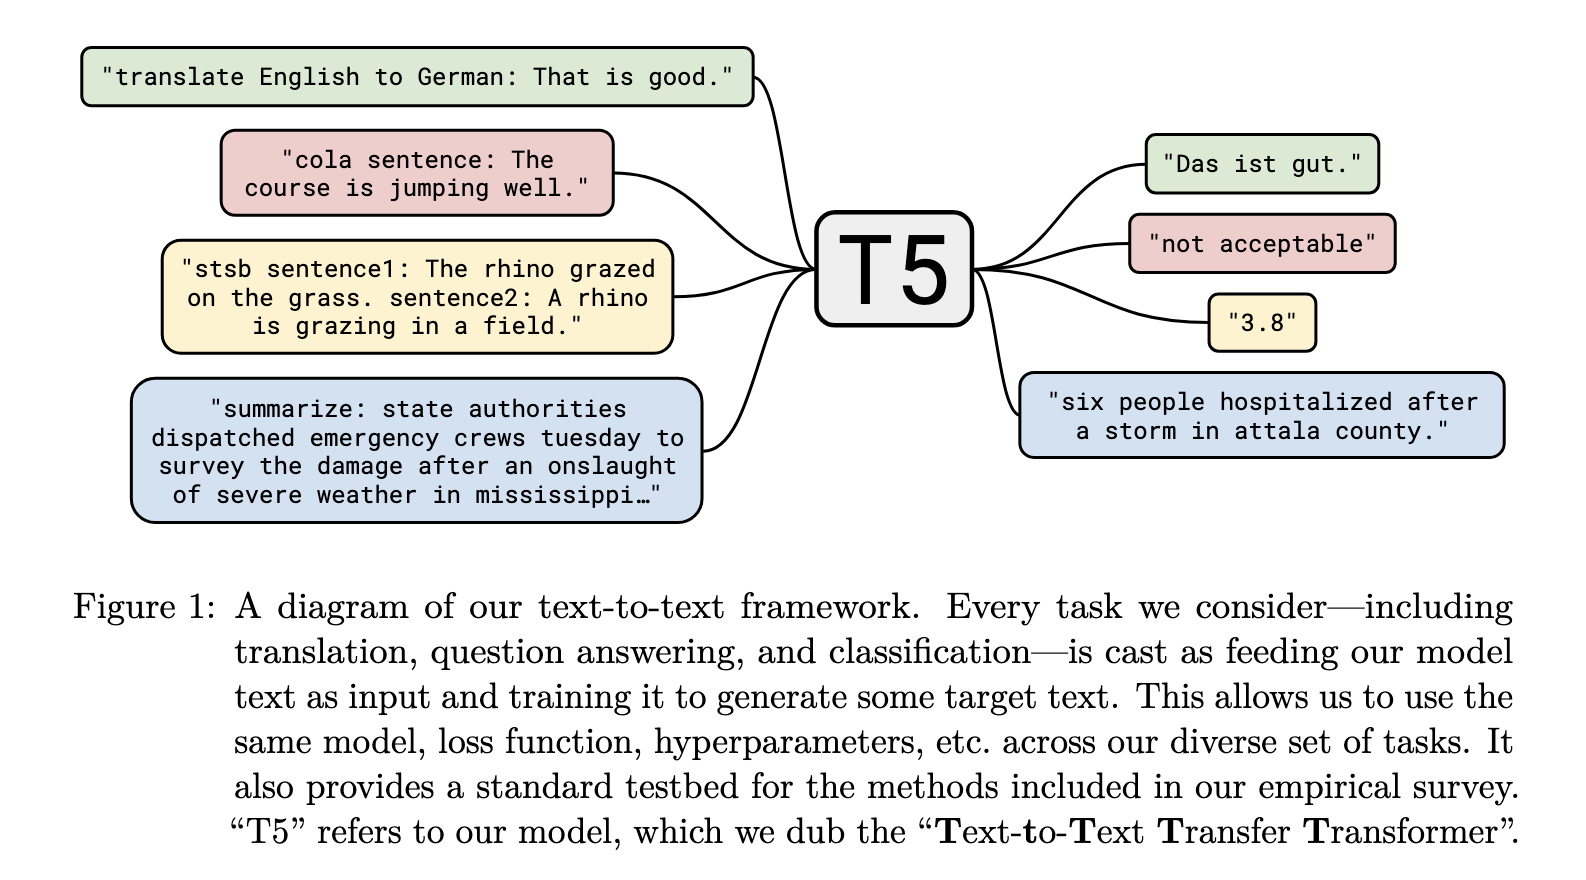

In [1]:
!pip install -q transformers

In [4]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers import pipeline

# Load the T5 model and tokenizer
model_name = "t5-base"  # You can choose other versions like t5-small or t5-large
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

# Using Hugging Face pipeline for easy task handling
# Summarization task
summarizer = pipeline("summarization", model=model, tokenizer=tokenizer)

# Translation task (from English to French)
translator = pipeline("translation_en_to_fr", model=model, tokenizer=tokenizer)

# 1. Summarization Example
print("Summarization Example:")
text_to_summarize = """The quick brown fox jumps over the lazy dog. The fox is fast and clever, while the dog is sleepy and slow. They live in a beautiful forest, where they encounter other animals and have many adventures."""
summary = summarizer(text_to_summarize, max_length=50, min_length=25, do_sample=False)
print("Summary:", summary[0]['summary_text'])

print("\n")

# 2. Translation Example (English to French)
print("Translation Example (English to French):")
text_to_translate = "Hello, how are you?"
translated_text = translator(text_to_translate)
print("Translated text:", translated_text[0]['translation_text'])

print("\n")


Device set to use cuda:0
Device set to use cuda:0


Summarization Example:
Summary: brown fox and lazy dog live in a beautiful forest . fox is fast and clever, while dog is sleepy and slow .


Translation Example (English to French):
Translated text: Bonjour, comment êtes-vous?




# Self-Supervised Learning

## [BERT - Bidirectional Encoder Representations from Transformers](https://arxiv.org/abs/1810.04805) (2018)

- **Параметров:** 110 миллионов (Base), 340 миллионов (Large)
- **Данные:** ~16 ГБ (BookCorpus + English Wikipedia)
- **Контекст:** 512 токенов
- **Количество слоев:** 12 (Base), 24 (Large)
- **Размерность скрытого состояния:** 768 (Base), 1024 (Large)
- **Pretraining GPU-месяцев (A100):** ~3,000
- **Оценка стоимости обучения:** ~$1,000,000 (Base)
- **Этапы обучения:** Pretraining + Fine-tuning


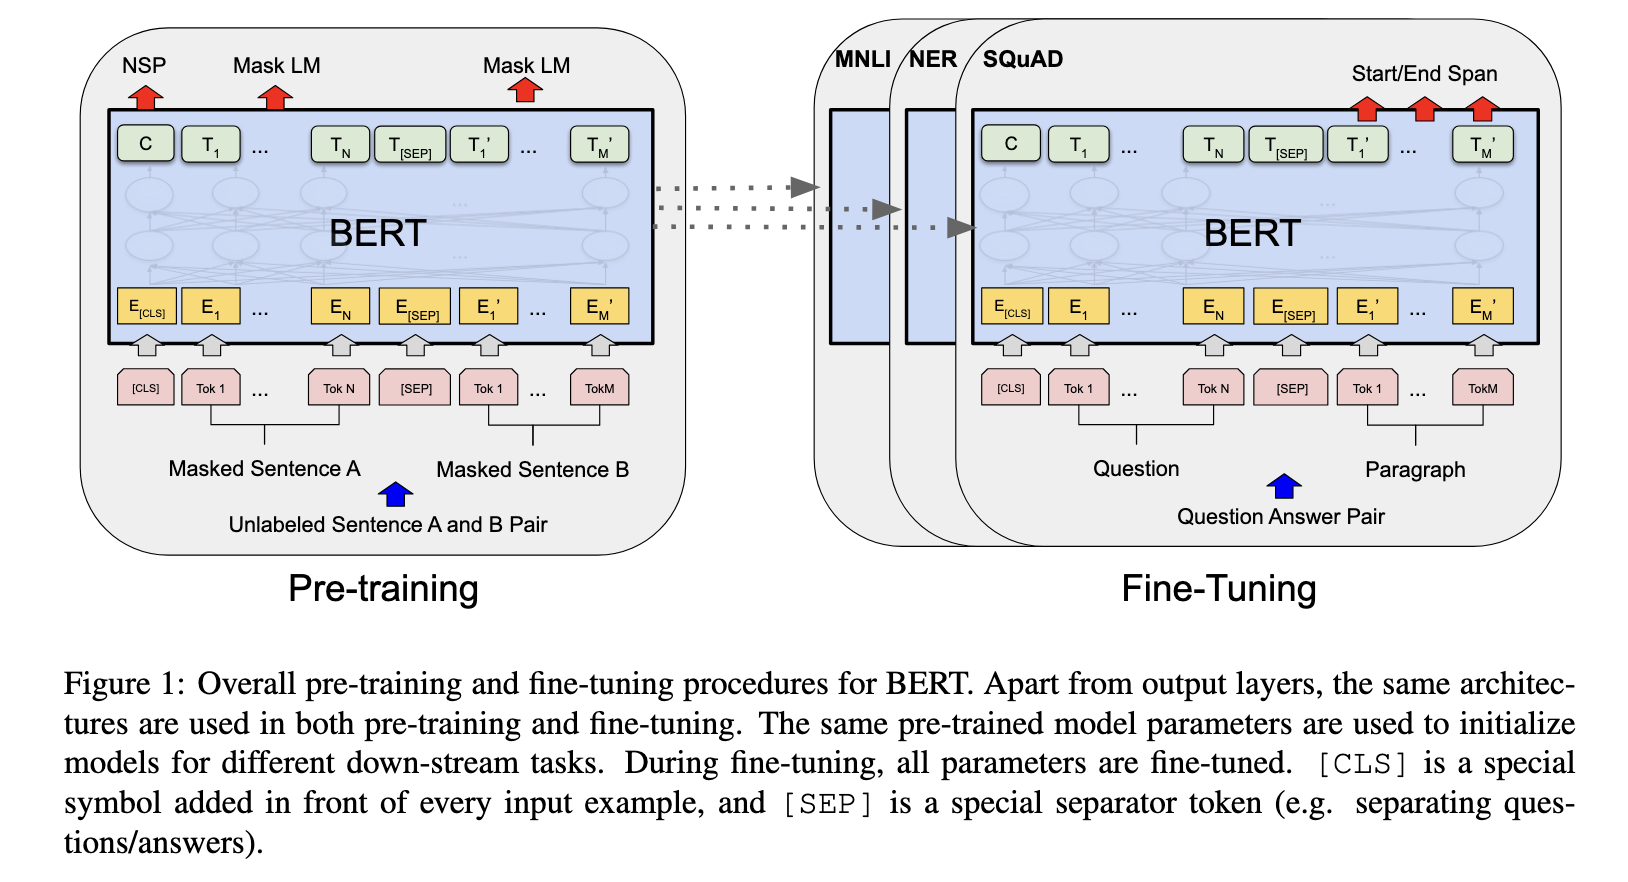


### Задачи

#### Этап 1: Претрейнинг (Pretraining)

1. **Masked Language Modeling (MLM)**  
   Модель маскирует случайные слова в тексте и пытается предсказать их. Эта задача помогает модели изучить контекстные связи между словами в предложении.

2. **Next Sentence Prediction (NSP)**  
   Модель предсказывает, логично ли одно предложение следует за другим, что помогает изучить взаимоотношения между предложениями.


---


#### Этап 2: Fine-Tuning (SFT - Supervised Fine-Tuning)
На этом этапе BERT адаптируется для выполнения конкретных задач с использованием размеченных данных.

##### Задачи на этапе Fine-Tuning:
1. **Классификация текста**  
   Применение: Определение темы или настроения текста, например, анализ отзывов, категоризация документов.

2. **Ответ на вопросы (Question Answering)**  
   Применение: Извлечение ответа из текста на основе заданного вопроса. Например, извлечение ответа на вопрос типа "Какая столица Франции?" из соответствующего контекста.

3. **Извлечение именованных сущностей (NER - Named Entity Recognition)**  
   Применение: Определение и классификация именованных сущностей в тексте (например, имена людей, организации, даты).

4. **Предсказание следующего предложения (Next Sentence Prediction, NSP)**  
   Применение: Определение, логично ли одно предложение следует за другим в контексте. Это может быть полезно для задач, связанных с анализом последовательности предложений.

5. **Тематическое моделирование (Topic Modeling)**  
   Применение: Выявление тем в большом наборе текстов, таких как классификация новостей по категориям.

6. **Парсинг зависимостей (Dependency Parsing)**  
   Применение: Анализ синтаксической структуры текста, выявление зависимостей между словами в предложении.

7. **Тегирование частей речи (POS tagging)**  
   Применение: Определение частей речи для каждого слова в предложении, что помогает понять структуру текста.

8. **Резюмирование текста (Text Summarization)**  
   Применение: Создание краткого изложения длинного текста или документа.

9. **Решение задач текстового сопоставления (Textual Entailment)**  
   Применение: Определение, поддерживает ли одно утверждение другое (согласие, противоречие или нейтральность).



In [6]:
from transformers import BertTokenizer, BertForMaskedLM, BertForNextSentencePrediction
from transformers import pipeline

# Load BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
mlm_model = BertForMaskedLM.from_pretrained("bert-base-uncased")
nsp_model = BertForNextSentencePrediction.from_pretrained("bert-base-uncased")

# 1. Masked Language Modeling (MLM)
def masked_language_modeling(text):
    # Mask a token in the input text for MLM
    input_text = f"Hello, my name is [MASK]."
    inputs = tokenizer(input_text, return_tensors="pt")
    outputs = mlm_model(**inputs)
    predictions = outputs.logits

    # Get the predicted token id
    predicted_token_id = predictions[0, 0, tokenizer.mask_token_id].argmax(dim=-1)
    predicted_token = tokenizer.decode(predicted_token_id)

    return predicted_token

# Example of MLM task
text = "Hello, my name is [MASK]."
predicted_token = masked_language_modeling(text)
print(f"Predicted token for '[MASK]' is: {predicted_token}")

# 2. Next Sentence Prediction (NSP)
def next_sentence_prediction(text_a, text_b):
    # Encode both sentences
    inputs = tokenizer(text_a, text_b, return_tensors="pt", truncation=True, padding=True)

    # Predict the relationship between the sentences (0: Does not follow, 1: Follows)
    outputs = nsp_model(**inputs)
    logits = outputs.logits
    prediction = logits.argmax(dim=-1).item()

    return "Next sentence follows" if prediction == 1 else "Next sentence does not follow"

# Example of NSP task
sentence_a = "I am learning BERT."
sentence_b = "It is a popular model for NLP tasks."
nsp_prediction = next_sentence_prediction(sentence_a, sentence_b)
print(f"NSP prediction: {nsp_prediction}")

sentence_a = "I am learning BERT."
sentence_b = "Today is monday."
nsp_prediction = next_sentence_prediction(sentence_a, sentence_b)
print(f"NSP prediction: {nsp_prediction}")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Predicted token for '[MASK]' is: [PAD]
NSP prediction: Next sentence follows
NSP prediction: Next sentence does not follow


# Large Language Models.

| Model   | \#Params | Data     | Context         | L  | H     | Pretraining Compute (A100) | Pretraining Cost |
|---------|----------|----------|------------------|----|-------|-------------------------------|----------------------------|
| GPT-2  (2019)  | 1.5B     | ~40 ГБ   | 1024      | 48 | 1600  | ~383 GPU-months               | ~\$690,000                 |
| GPT-3  (2020) | 175B     | ~570 ГБ  | 2048      | 96 | 12288 | ~3,867 GPU-months            | ~\$6,970,000               |
| GPT-4  (2023) | >1T*     | ???      | 128k      | ?  | ?     | ~123,333 GPU-months         | ~\$221,999,000             |


## Training Stages

### Pretraining

**Задача:** Next Token Prediction (NTP)

**Данные:** Большое количество текстовых данных из интернета.

**Цель:** Научить модель базовому пониманию языка, грамматики, фактов, логики и шаблонов текста. Это создаёт универсальные языковые способности. Наибольшее количество "знаний" модель выучивает на этом этапе.

---

### SFT (Supervised Fine-Tuning)

**Данные:** На порядки меньше данных, чем в Pretraining. Умение вести диалог, следование инструкциям.

**Цель:**  Превратить «нейтральную» модель в ассистента, способного понимать инструкции и выполнять конкретные задачи с высокой точностью и релевантностью.

---

### Alignment (RL)

*Для семейства GPT, применяется начиная с GPT4*

**Данные:** Зависит от алгоритма обучения. Для `RLHF` нужна разметка аннотаторов с выбором предпочтения. Для `GRPO` не нужна разметка, данные сэмплируются самой моделью.

**Цель:** Сделать модель полезной, безопасной и соответствующей человеческим ценностям.


# In context learning

ICL - возможность модели адаптироваться к запросу, без обновления весов модели
* Через ICL можно "внедрить" новые знания в модель
* Благодаря ICL работает следование инструкциям даже в моделях, которые не обучались специально следованию инструкциям (GPT2)

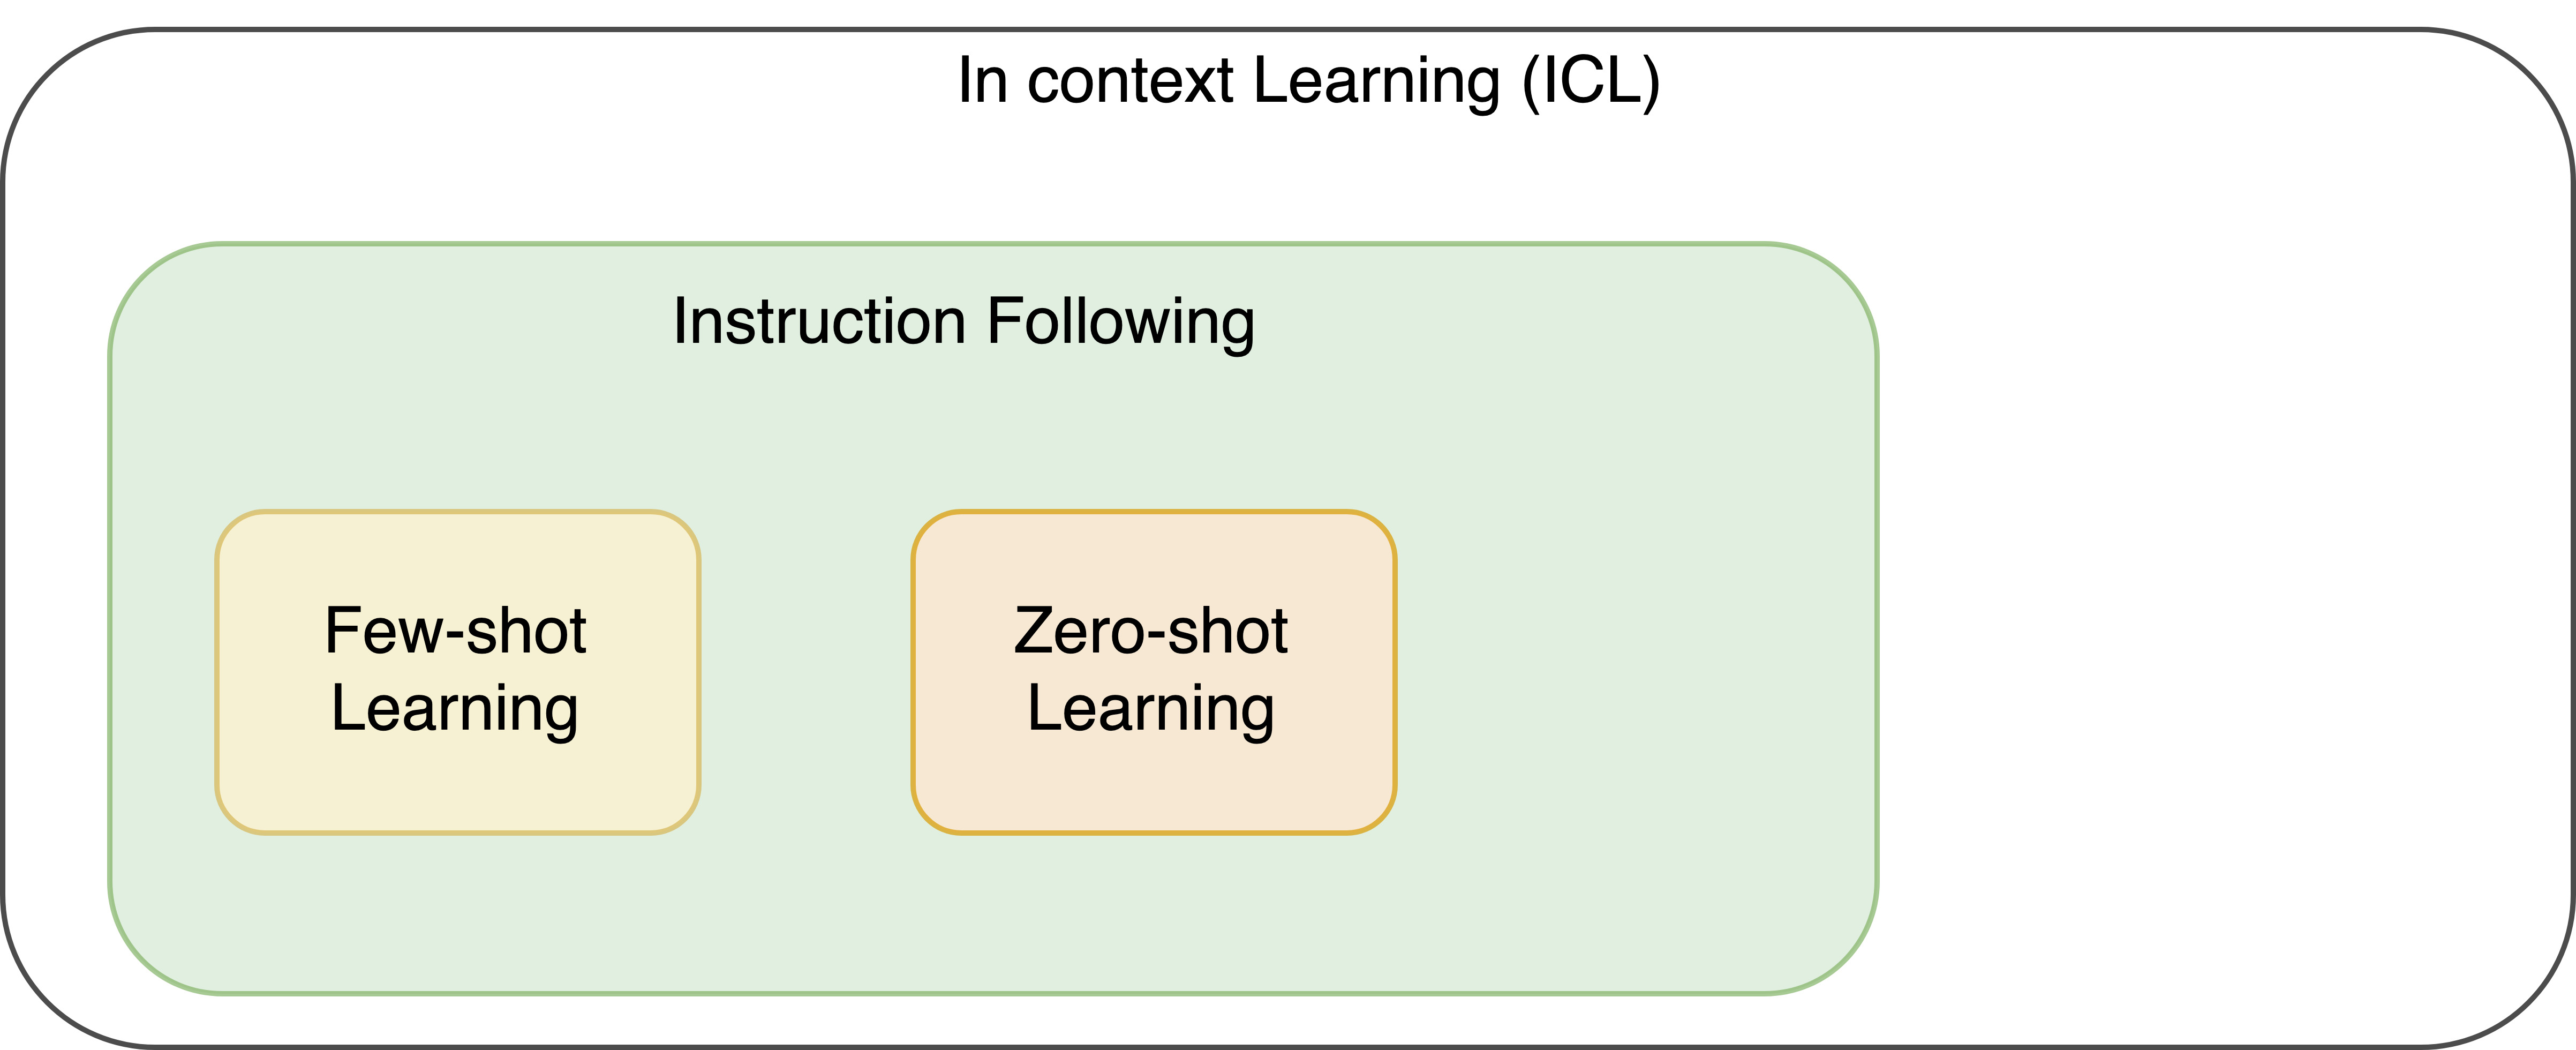

## Zero-shot learning

## Few-shot learning


In [11]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load pre-trained GPT-2 model and tokenizer
model_name = "openai-community/gpt2"
model = GPT2LMHeadModel.from_pretrained(model_name)
model = model.to(device)

tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# Function to perform zero-shot translation with GPT-2
def gpt2_generate(prompt, max_length=100):
    # Encode the prompt text (translation request)
    inputs = tokenizer.encode(prompt, return_tensors="pt")
    inputs = inputs.to(device)

    # Generate the translation from the prompt
    outputs = model.generate(inputs, max_length=max_length, num_return_sequences=1, no_repeat_ngram_size=2, temperature=0.7, top_p=0.9)

    # Decode the generated text (the translation)
    translated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return translated_text

# Example of zero-shot translation from English to French
prompt = "A = 500, B = 500. A + B ="
translated_text = gpt2_generate(prompt)

# Display the translated text
print(f"Translated Text: {translated_text}")


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Translated Text: A = 500, B = 500. A + B = 1000.

The first two values are the values of the two variables. The third value is the value of each variable. This is called the "value of a variable".
. . .
 (a = 1, b = 2, c = 3, d = 4, e = 5, f = 6, g = 7, h = 8, i = 9, j = 10, k = 11, l =


# Few-Shot




In [12]:
prompt = "A = 100, B = 200, C = 300. How much would be D + E?"
translated_text = gpt2_generate(prompt)

# Display the translated text
print(f"Translated Text: {translated_text}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Translated Text: A = 100, B = 200, C = 300. How much would be D + E?

A + B + C + D = 1.5 × 10−6 = 0.8 × 1010.
. The value of D is the sum of the values of B and C. If D > 0, then the value is 0 × 100. This is because the number of values is equal to the total number (i.e., the square root of all the numbers


# Scaling Laws

### FLOPS - **FL**oating-point **OP**erations per **S**econd

### **M**ultiply-**ACC**umulate

$$ FLOPS = MAC * 2 $$


## [DeepMind Chinchilla: Training Compute-Optimal Large Language Models](https://arxiv.org/abs/2203.15556) (2022)

* [**gonzo_ML разбор**](https://t.me/gonzo_ML/1216)

**Проблема:** мы вообще говоря, не знаем, как скейлить модели. На сколько должен вырасти объем данных, при увеличении кол-ва параметров модели?

**Цель:** Вывести закон или формулу, по которой при фиксированном количестве вычислительного бюджета, можно оценить количество параметров модели и количество токенов, необходимых для обучения.

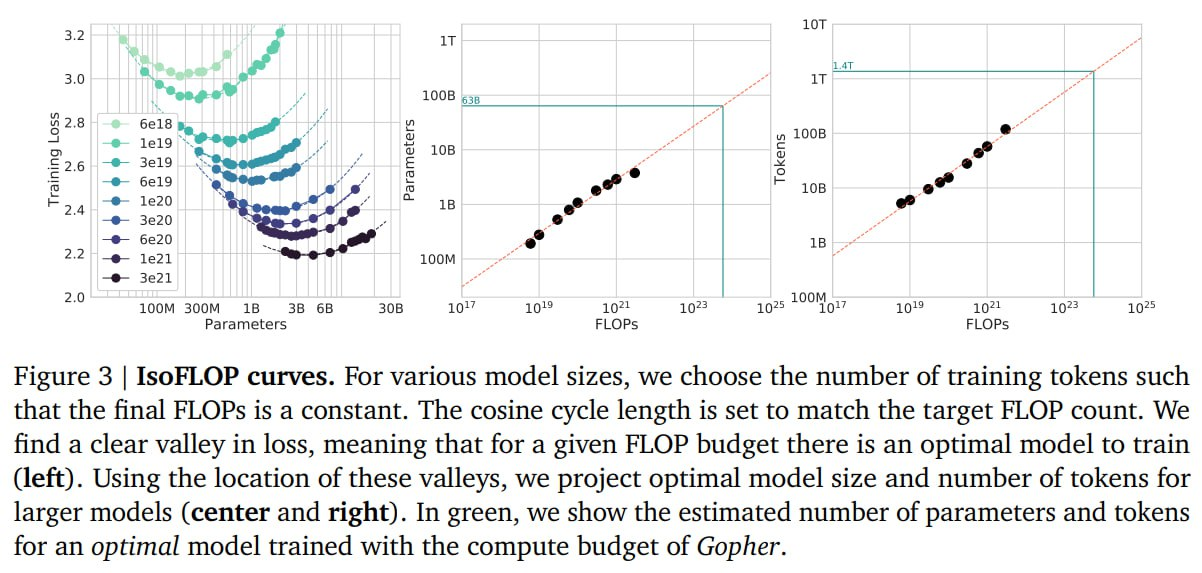

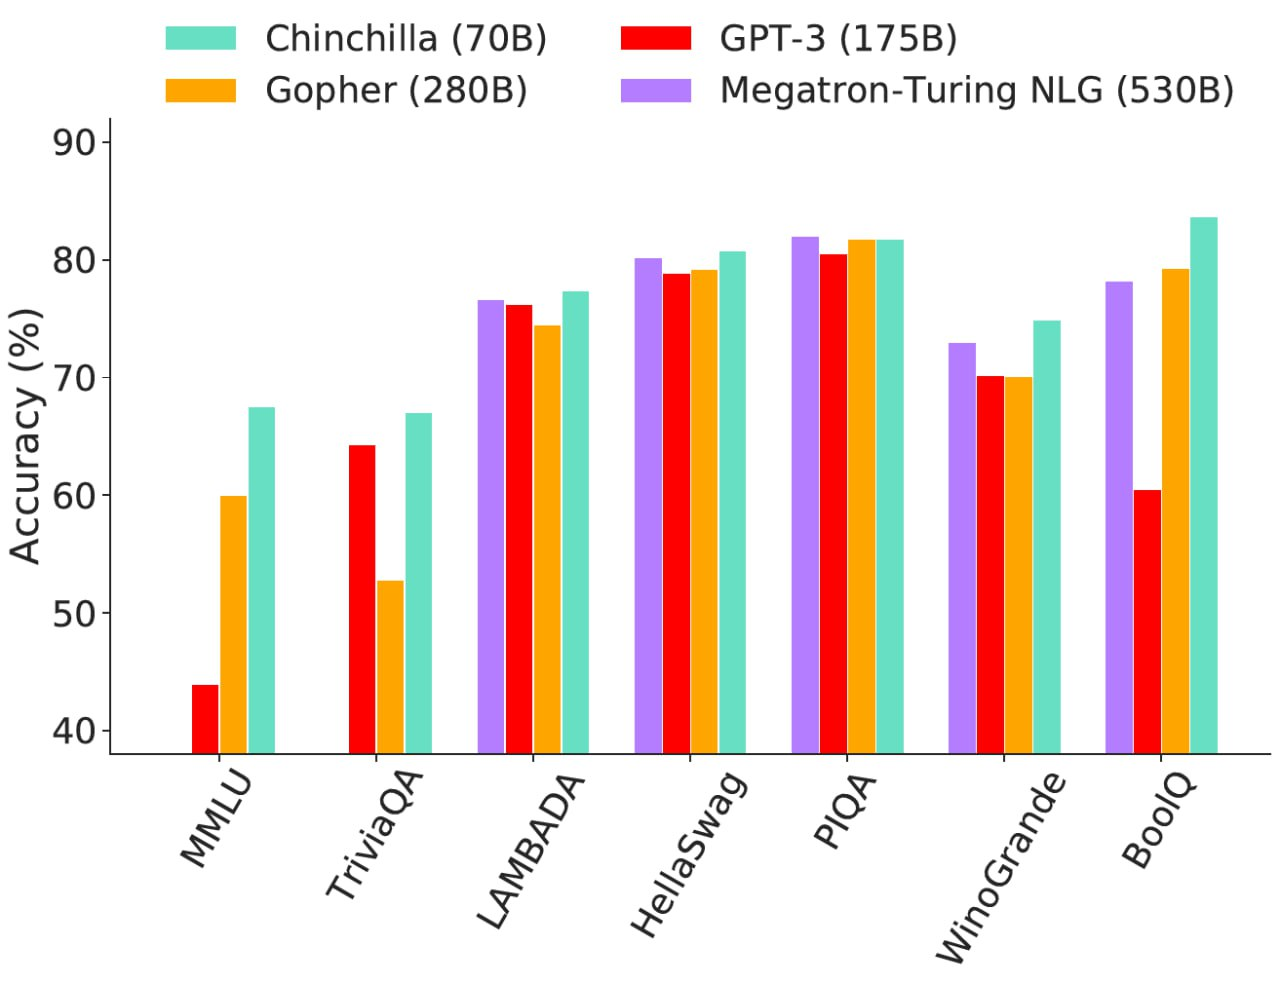

| Model      | Parameters (N) | Tokens Trained On (D) |
|------------|----------------|------------------------|
| Gopher     | 280B           | 300B                  |
| Chinchilla | 70B            | 1.4T                  |

**Note**: Fixed Training Budget



**Nota bene** Chinchilla Scaling Law:


$$ \frac{Tokens}{Parameters} = \frac{1400B}{70B}  = 20 $$


## In Fact

| Model               | Parameters (N) | Tokens (D) | D / N Ratio |
|---------------------|----------------|-------------|-------------|
| Gopher              | 280B           | 300B        | 1.07        |
| Chinchilla          | 70B            | 1.4T        | 20.00       |
| Qwen-72B            | 72B            | 3.0T        | 41.67       |
| DeepSeek-671B       | 671B           | 14.8T       | 22.06       |
| Llama-3.1-405B      | 405B           | 15T         | 37.04       |
| Llama-4-Scout-109B  | 109B           | ~40T        | ~36.70      |


# Distributed Training

Го в [Ultra-Scale Playbook](https://huggingface.co/spaces/nanotron/ultrascale-playbook?section=high_level_overview)

> Как в зависимости от количества параметров модели меняется количество и распределениие видеопамяти?




# [DataParallel](https://pytorch.org/docs/stable/generated/torch.nn.DataParallel.html)

**DEPRECATED!**

* GIL - реализация на тредах - не позволит полностью загрузить несколько GPU
* Работает только на одной ноде (узле, сервере)
* Нет причин использовать, потому что Distributed Data Parallel быстрее и его не сильно сложнее использовать



# [Distributed Data Parallel](https://pytorch.org/docs/stable/generated/torch.nn.parallel.DistributedDataParallel.html)

**Идея:** Копируем веса модели на `N` `GPU`. Делаем параллельно Forward и Backeward pass. Синхронизируем градиенты на одной GPU и делаем шаг обновления весов.

**Плюсы:**
* Самый простой вариант распределенного обучения
* Может работать в мульти-нодовом режиме, можно отмасштабировать больше чем на 1 GPU

**Минусы:**
* Дублируются веса модели на разных GPU
* Дублируются состояния оптимизатора
* Не будет работать, если нужно обучить модель, которая не помещается на 1 GPU


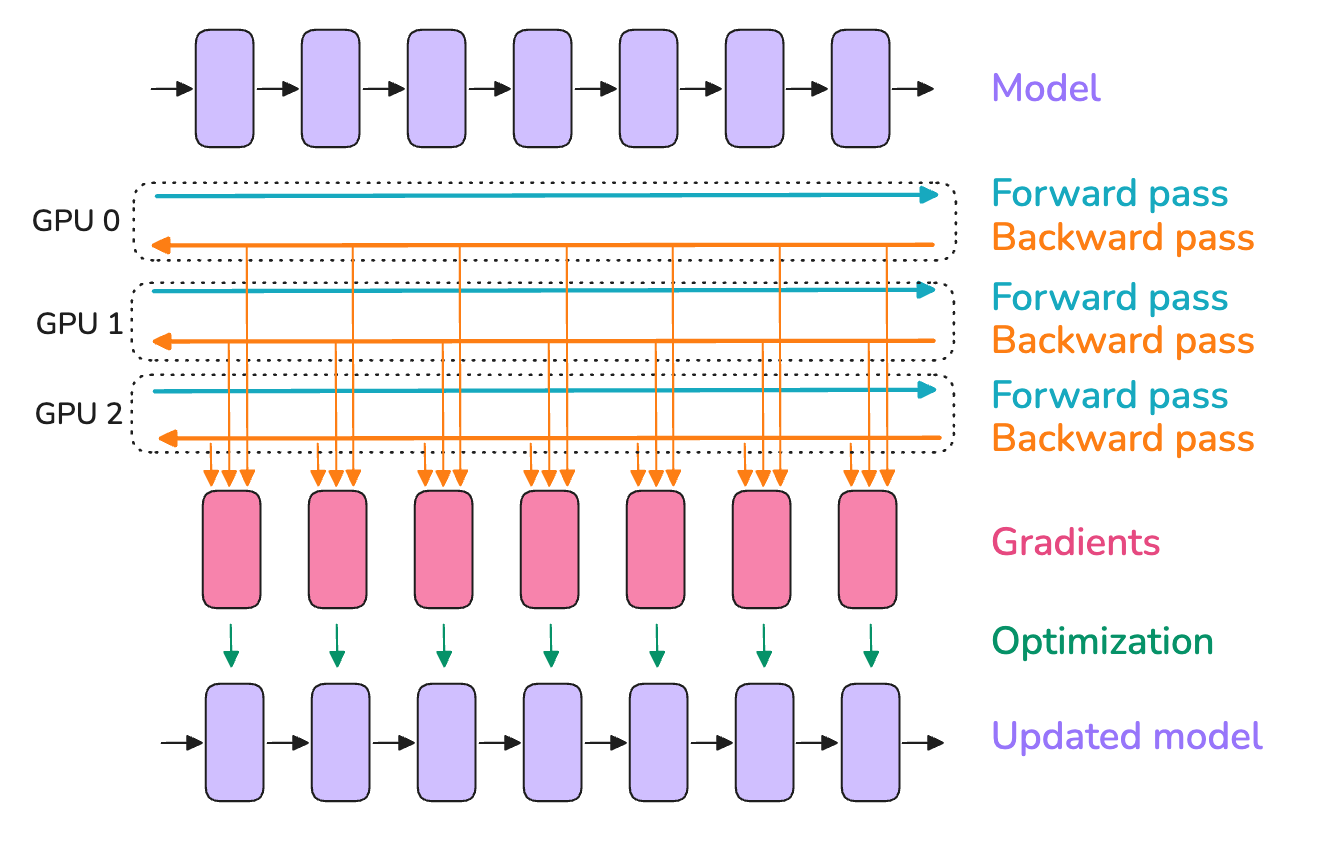

## DeepSpeed

**Идея:**
* За счет накладных расходов на коммуникацию между GPU, можно на разных GPU держать не полную копию градиентов/состояний оптимизатора/весов, а только часть

**Результат:**
* Первая опенсорсная библиотека для обучения очень больших моделей, которые не помещаются на 1 GPU


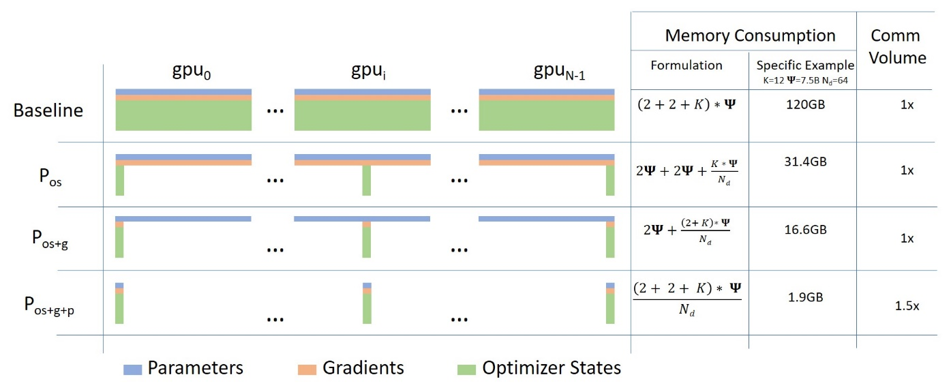

## FSDP

**Идея:**
* Такая же как DeepSpeed
* Встроен в Pytorch

**Результат:**
* Де-факто стандарт в распределенном обучении

```yaml
compute_environment: LOCAL_MACHINE
debug: false
distributed_type: FSDP
downcast_bf16: 'no'
fsdp_config:
  fsdp_auto_wrap_policy: TRANSFORMER_BASED_WRAP
  fsdp_backward_prefetch_policy: BACKWARD_PRE
  fsdp_forward_prefetch: false
  fsdp_cpu_ram_efficient_loading: true
  fsdp_offload_params: false
  fsdp_sharding_strategy: FULL_SHARD
  fsdp_state_dict_type: SHARDED_STATE_DICT
  fsdp_sync_module_states: true
  fsdp_transformer_layer_cls_to_wrap: BertLayer
  fsdp_use_orig_params: true
machine_rank: 0
main_training_function: main
mixed_precision: bf16
num_machines: 1

# В колабе только 1 GPU, поэтому сделать настоящую демку в колабе не получится
num_processes: 2
rdzv_backend: static
same_network: true
tpu_env: []
tpu_use_cluster: false
tpu_use_sudo: false
use_cpu: false
```

In [ ]:
!git clone https://github.com/huggingface/accelerate/

In [ ]:
!cd ./accelerate && accelerate launch examples/nlp_example.py

## YaFSDP

* [**Хабр**](https://habr.com/ru/companies/yandex/articles/817509/)
* [**Репозиторий**](https://github.com/yandex/YaFSDP)
* [**Доклад на Yandex Open Source Jam**](https://vkvideo.ru/video-17796776_456241249)

**Проблема:** неоптимальные коммуникации во время распределенного обучения. Не до конца утилизиррован поток вычислений.

**Решение:** Руками захардкодить и подкостылить обработку RMS/LayerNorm слоев

**Результат:** Инженерные трюки помогли добиться ускорения до 25% для обучения LLM.



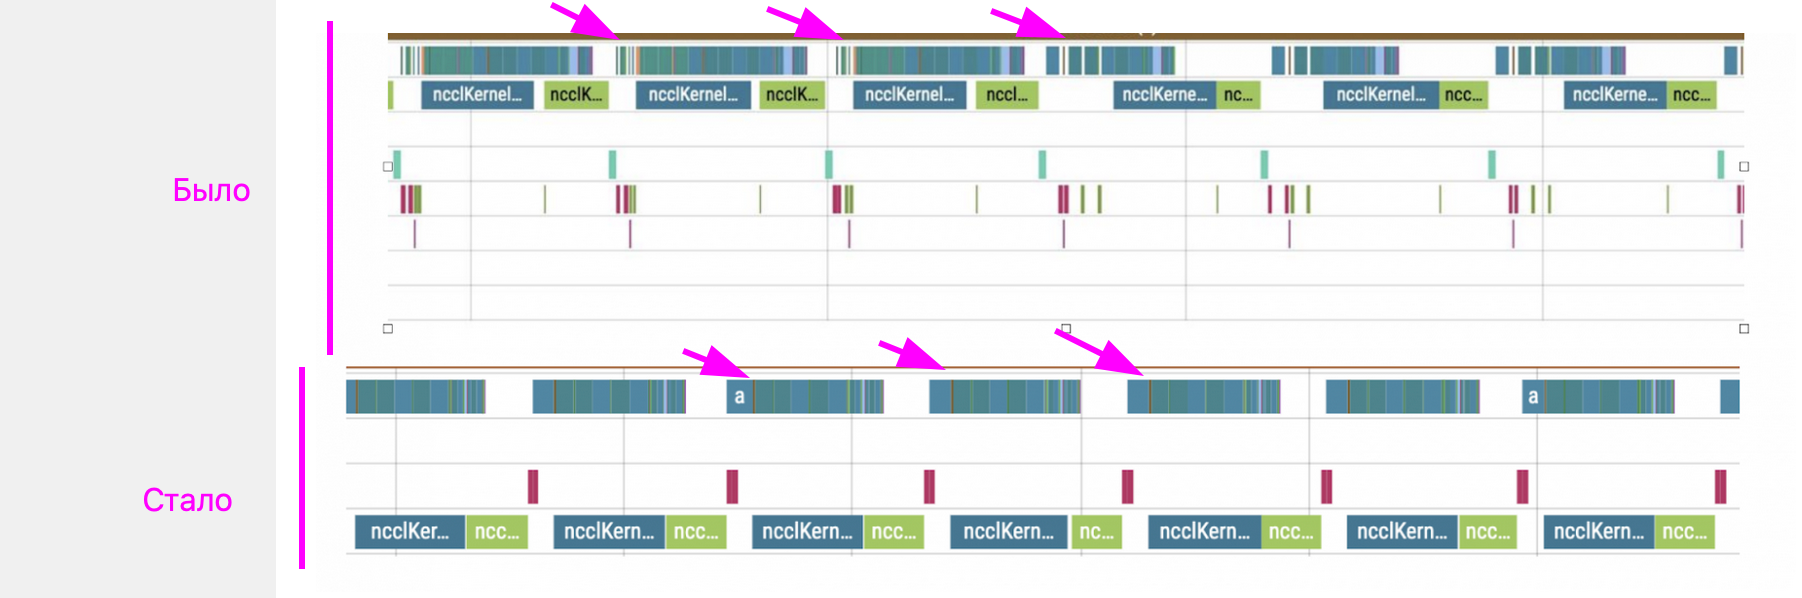

---

# Итого:

| Характеристика                     | DDP                             | DeepSpeed                                             | FSDP                                          |
|------------------------------------|----------------------------------|--------------------------------------------------------|-----------------------------------------------|
| **Поддержка моделей > 1 GPU памяти** | ❌                              | ✅                                                    | ✅                                             |
| **Использование памяти**           | Высокое                          | Эффективное                                      |  Эффективное             |
| **Масштабируемость (много GPU/нод)** | ✅                              | ✅                                                    | ✅                                             |
| **Простота использования**         | ✅ (просто встроить в PyTorch)   | ⚠️ Несложно с Accelerate | ⚠️ Несложно с Accelerate |
| **Поддержка Offloading**           | ❌                              | ✅ (CPU, NVMe)                                         | ✅ (CPU, но ограниченно)                       |
| **Гибкость и настройка**           | Базовая                         | Высокая (много стратегий и параметров)                | Средняя (через параметры шардинга)            |


**Резюме:**
* DDP - начинаем с него, если модель помещается на 1GPU
* FSDP - предпочтительнее DeepSpeed в среднем, если пилим с нуля
* DeepSpeed - если в репозитории уже используется DeepSpeed и он работает и не мешает, пользуйтесь DeepSpeed. Это не то место, которое в первую очередь надо трогать в исследовательских целях.


**Как еще больше можно расшардить обучение?**
* [Tensor Parallelism](https://huggingface.co/spaces/nanotron/ultrascale-playbook?section=tensor_parallelism) - шардируем активации
* [Pipeline Parallelism](https://huggingface.co/spaces/nanotron/ultrascale-playbook?section=pipeline_parallelism) - оптимизируем порядок утилизации GPU и коммуникации так, чтобы не было простоев




# Torch Distributed Elastic

**Идея:** Позволяет динамически добавлять и убирать процессы (и узлы) во время распределённого обучения. Подходит для нестабильных/предэмптивных кластеров, например, в облаке или на спотовых инстансах.

**Плюсы:**

* Устойчивость к падению нод (fault-tolerant)
* Поддержка Elastic Training — можно добавлять/удалять воркеры на лету
* Удобно для облачных систем, где возможны спотовые прерывания
* Работает с DDP, FSDP, DeepSpeed и др. распределёнными стратегиями

**Минусы:**

* Требует специфического старта через torchrun с поддержкой Elastic
* Нужно, чтобы код был написан с учётом повторной инициализации и checkpoint-ов
* Не ускоряет обучение сам по себе — работает в связке с DDP/FSDP/DeepSpeed

---

**Задачка:**

> Мы запустили обучаться LLM на кластере 100_000 GPU. Обучение должно занять около 1 месяца.  Вероятность, что одна GPU выйдет из строя за один день составляет 0.1%. С какой вероятностью из строя выйдет хотя бы одна GPU за месяц обучения. Какое мат ожидание коичества вышедших из строя GPU в месяц?


**Ответ**

```
Вероятность хотя бы одного сбоя за месяц	≈ 100%
Мат. ожидание числа вышедших из строя GPU	3 000 GPU
```

# LLM Eval

# Обзор бенчмарков для LLM

| Бенчмарк       | Область оценки              | Описание                                                                 | Примеры задач                             |
|----------------|-----------------------------|--------------------------------------------------------------------------|-------------------------------------------|
| **MMLU**       | Знания, мультидисциплинарность | Massive Multitask Language Understanding, проверяет знания по 57 предметам | История, медицина, математика и др.       |
| **HELLASWAG**  | Здравый смысл               | Проверка способности дополнять предложения логически                      | Завершение предложений                     |
| **ARC**        | Научные знания (K-12)       | AI2 Reasoning Challenge, тест школьного уровня                           | Научные вопросы с множественным выбором   |
| **GSM8K**      | Арифметика и рассуждение    | Grade School Math 8K — математические задачи для начальной школы        | Задачи на многошаговое рассуждение        |
| **TruthfulQA** | Правдоподобие vs. достоверность | Проверка способности избегать "убедительной, но ложной" информации       | Вопросы на правдивость                    |
| **WinoGrande** | Разрешение кореференций     | Проверка способности понимать, к кому относится местоимение              | Задачи в стиле Winograd Schema            |
| **OpenBookQA** | Комбинированные знания      | Требует знаний из "открытой книги" и способности их применять            | Применение фактов для вывода              |
| **HumanEval**  | Генерация кода              | Проверка способности LLM генерировать код, который проходит тесты        | Программные задачи с проверкой решений    |
| **MT-Bench**   | Диалоговые способности      | Multi-turn chat benchmark, фокус на диалогах и инструментах              | Рейтинги на основе GPT-4 / человеческих   |


# Сравнение плюсов и минусов оценочных подходов LLM

| Подход             | Плюсы                                                                 | Минусы                                                                 |
|--------------------|------------------------------------------------------------------------|------------------------------------------------------------------------|
| **Likelihood-based** | - Объективная и воспроизводимая метрика<br>- Эффективен по ресурсам<br>- Подходит для обучения и fine-tuning<br>- Хорош в zero-shot режиме | - Не отражает поведение генерации<br>- Чувствителен к формулировкам<br>- Может переоценивать запомненные ответы |
| **Decoding-based**   | - Ближе к реальному использованию<br>- Гибкая оценка: стиль, логика, креативность<br>- Учитывает reasoning и формат вывода | - Зависит от метода декодирования<br>- Требует human evaluation или сложных метрик<br>- Вычислительно дорогой<br>- Ошибки парсинга |


# Не все так просто:
* Бенчмарки утекают
* Использовать людей для оценки LLM может быть дорого и долго (а иногда не надежно) - LLM Arena
* Можно использовать отдельную LLM для оценки новой модели. Но такая оценка может быть смещена


# Полезные материалы:
* Человек и LLM. Как оценивать качество моделей и строить метрики - [**Habr**](https://habr.com/ru/companies/yandex/articles/861084/), [**Yandex Education (есть запись)**](https://habr.com/ru/companies/yandex/articles/861084/)


## MMLU Example

```
📘 Category: High School Biology

> Which of the following processes is part of cellular respiration?

A) Photosynthesis
B) Glycolysis
C) Transcription
D) DNA replication
✅ Correct Answer: B) Glycolysis
```

# Специфичные бенчмарки

## 📝 Суммаризация
| Бенчмарк     | Описание                                                        |
|--------------|-----------------------------------------------------------------|
| CNN/DailyMail | Суммаризация новостных статей, часто используется как стандарт |
| XSum         | Более абстрактная и сжатая суммаризация BBC-статей              |
| TL;DR (Reddit) | Суммаризация пользовательских постов в стиле TL;DR            |
| SummEval     | Human-based оценка разных моделей суммаризации                  |

## 💻 Написание кода
| Бенчмарк     | Описание                                                        |
|--------------|-----------------------------------------------------------------|
| HumanEval    | Генерация кода Python и прохождение юнит-тестов                |
| MBPP         | Mostly Basic Programming Problems, задачи начального уровня     |
| CodeContests | Решение задач с платформ вроде Codeforces                       |
| APPS         | Программные задачи школьного и университетского уровня          |

## 📋 Следование инструкциям
| Бенчмарк     | Описание                                                        |
|--------------|-----------------------------------------------------------------|
| AlpacaEval   | Сравнение моделей по качеству следования инструкциям            |
| FLAN         | Fine-tuned LMs Across Numerous tasks (инструкции широкого спектра) |
| MT-Bench     | Диалоговое тестирование следования задачам и инструментам       |
| TuluEval     | Оценка моделей с точки зрения послушности, полезности и честности|

## ➗ Математика
| Бенчмарк     | Описание                                                        |
|--------------|-----------------------------------------------------------------|
| GSM8K        | Школьная арифметика с пошаговыми объяснениями                   |
| MATH         | Сложные задачи для старшей школы и олимпиадного уровня          |
| MathQA       | Вопросы с многошаговым решением и генерацией уравнений          |
| AR-LSAT Math | Логико-математические задачи, похожие на LSAT                   |


# [lm-evaluation-harness](https://github.com/EleutherAI/lm-evaluation-harness)

In [ ]:
!git clone --depth 1 https://github.com/EleutherAI/lm-evaluation-harness
!cd lm-evaluation-harness && pip install -e .

In [9]:
!lm_eval --model hf \
    --model_args pretrained=openai-community/gpt2 \
    --tasks triviaqa \
    --device cuda:0 \
    --batch_size 128

2025-04-14 12:45:30.173314: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744634730.208544    4276 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744634730.219606    4276 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-14 12:45:30.254354: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-14:12:45:46 INFO     [__main__:440] Selected Tasks: ['triviaqa']
2025-04-14:12:45:46 INFO     [evaluator:185]

In [11]:
!lm_eval --model hf \
    --model_args pretrained=openai-community/gpt2 \
    --tasks triviaqa \
    --device cuda:0 \
    --batch_size 128 \
    --num_fewshot 5

^C


#  [🤗 LightEval](https://huggingface.co/docs/lighteval/quicktour)

In [4]:
!pip install -q lighteval[math] tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 30.3 MB/s eta 0:00:00


In [5]:
!lighteval accelerate "pretrained=openai-community/gpt2" "lighteval|triviaqa|0|0"

[2025-04-14 12:33:16,787] [    INFO]: NumExpr defaulting to 2 threads. (utils.py:162)
[2025-04-14 12:33:17,278] [    INFO]: PyTorch version 2.6.0+cu124 available. (config.py:54)
[2025-04-14 12:33:17,280] [    INFO]: Polars version 1.21.0 available. (config.py:66)
[2025-04-14 12:33:17,281] [    INFO]: Duckdb version 1.2.1 available. (config.py:77)
[2025-04-14 12:33:17,282] [    INFO]: TensorFlow version 2.18.0 available. (config.py:112)
[2025-04-14 12:33:17,283] [    INFO]: JAX version 0.5.2 available. (config.py:125)
2025-04-14 12:33:18.368272: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744633998.456166    1153 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744633998.477148    1153 cuda_blas.cc:1418] Unable to register cuBLAS factory: 

Результат zero-shot
```
|        Task        |Version|Metric|Value |   |Stderr|
|--------------------|------:|------|-----:|---|-----:|
|all                 |       |qem   |0.0049|±  |0.0005|
|lighteval:triviaqa:0|      0|qem   |0.0049|±  |0.0005|
```

In [10]:
!lighteval accelerate "pretrained=openai-community/gpt2" "lighteval|triviaqa|5|0"

[2025-04-14 13:24:04,715] [    INFO]: NumExpr defaulting to 2 threads. (utils.py:162)
[2025-04-14 13:24:05,044] [    INFO]: PyTorch version 2.6.0+cu124 available. (config.py:54)
[2025-04-14 13:24:05,046] [    INFO]: Polars version 1.21.0 available. (config.py:66)
[2025-04-14 13:24:05,047] [    INFO]: Duckdb version 1.2.1 available. (config.py:77)
[2025-04-14 13:24:05,048] [    INFO]: TensorFlow version 2.18.0 available. (config.py:112)
[2025-04-14 13:24:05,049] [    INFO]: JAX version 0.5.2 available. (config.py:125)
2025-04-14 13:24:05.896548: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744637045.932667   14036 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744637045.943640   14036 cuda_blas.cc:1418] Unable to register cuBLAS factory: 

Результат 5-shot

```
|        Task        |Version|Metric|Value |   |Stderr|
|--------------------|------:|------|-----:|---|-----:|
|all                 |       |qem   |0.0144|±  |0.0009|
|lighteval:triviaqa:5|      0|qem   |0.0144|±  |0.0009|
```

---

# [How to Read a Paper?](https://web.stanford.edu/class/ee384m/Handouts/HowtoReadPaper.pdf)

### THE THREE-PASS APPROACH

1. The first pass gives you a general idea about the paper.
2. The second pass lets you grasp the paper’s content, but not its details.
3. The third pass helps you understand the paper in depth. (with Appendix)

# [Инструменты исследователя](https://fintech-dl-hse.github.io/course/pages/process/tools.html)

Ссылка + демо инструментов


# Полезные ресурсы

* [Мини курс "Полная история семейства GPT"](https://www.youtube.com/watch?v=l-l82uNwyu8&list=PLy6K3_Hx-udj6n1S88Vslyw2QVxSXLP2c) - Игорь Котенков
* [Ultrascale-Playbook](https://huggingface.co/spaces/nanotron/ultrascale-playbook) - практический гайд, как лучше всего скейлить вычисления
* [llm-foundry](https://github.com/mosaicml/llm-foundry) - трейним LLM в проде
* [Olmo](https://github.com/allenai/OLMo) - Больше для исследовательских целей. Код обучения и евала, промежуточные чекпоинты, [**логи обучения**](https://wandb.ai/ai2-llm/OLMo-2-1124-7B/reports/OLMo-2-7B-Nov-2024--VmlldzoxMDUzMzE1OA)
* [gonzo_ML разбор scaling laws](https://t.me/gonzo_ML/1216)


# Блиц

### Почему self-supervised pretraining -- это круто? Ведь для конкретной задачи все равно нужно делать finetuning.

<!--
Данных, которые доступны для обучения без учителя (self-supervised pretraining) на порядки больше, чем
размеченных данных. Поэтому важно "базовое" понимание языка получить на большом масштабе и использовать обощающие способности на локальной задаче.
-->

### Чем задача LM (Language Modeling) отличается от MLM (Masked Language Modeling)? Приведите примеры моделей, которые используют соответствующие задачи в обучении.

<!--

LM - задача предсказывания текена-за токеном по одному.

MLM - задача предсказать реальный токен по маске. Токены маскируются в 15% случаев.

В этих 15% надо предсказать исходный токен:
* В 80% (0.15*0.8 в абсолюте) используется [MASK] токен
* В 10% (0.15*0.1) используется рандомный токен
* В 10% (0.15*0.1) используется исходный токен

Примеры:
* LM: T5, GPT, VanillaTransformer
* MLM: BERT, RoBerta, DistilBERT

 -->


## Можно ли использовать Bert для генерации текстов?

<!--
Вообще говоря, изкоробки Bert не предназначена для задачи генерации. Только для задачи классификации или MLM.

Но! В теории, можно через разные методы заставить encoder-only трансформер решать задачу генерации.
См [non autoregressive transformers](https://github.com/LitterBrother-Xiao/Overview-of-Non-autoregressive-Applications) -->

## Чем отличается Transformer Encoder от Transformer Decoder?

<!--
На логическом уровне на примере задачи перевода:
* Encoder запускается 1 раз для генерации контекстных эмбэддингов входной последовательности
* Decoder запускается N раз для генерации N токенов. Отвечает за генерацию токенов целевой последовательности

На уровне архитектуры:
* в Encoder есть только self-attention последовательности.
* Decoder есть self-attention + cross-attention.
 -->

## Чем отличаются стадии SFT и Pretrain?


## Чем отличаются стадии SFT и Allignment?


## Почему zero-shot способности T5 хуже, чем у GPT-3?